# Classificador Bayesiano - Mistura de Gaussianas

Este trabalho consiste na implementação de um Classificador Bayesiano para separar as
duas classes de uma base de dados "duas espirais"(esta base de dados pode ser amostrada
utilizando a função mlbench.spirals, do pacote mlbench em R). 

Cada classe será modelada como uma mistura de gaussianas de duas dimensões. Os pontos que definirão os parâmetros de cada uma das gaussianas do modelo serão definidos através de um algoritmo de Clustering (i.e: K-Means).

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from random import randrange
from matplotlib import style
style.use('ggplot')
import copy
from scipy.spatial import distance
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

## Dados

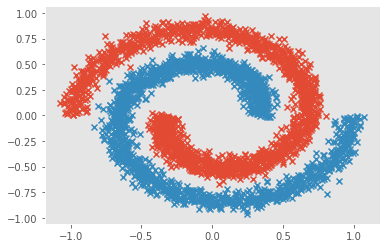

In [2]:
spirals_dataset = pd.read_csv('data/spirals.csv')
y = spirals_dataset.iloc[:,2].astype(int).to_numpy()
X = spirals_dataset.iloc[:,0:2].astype(float).to_numpy()
y[y==2] = 0
col = ['blue', 'red']
for class_value in [0, 1]:
    # get row indexes for samples with this class
    row_ix = np.where(y == class_value)
    # create scatter of these samples
    plt.scatter(X[row_ix, 0], X[row_ix, 1], marker='x', cmap='Paired')
plt.grid()

## Implementação do k-Means
Primeiramente foi desenvolvido o kMeans. Se trata de um algoritmo de aprendizado não supervisionado para clusterização (ou agrupamento). Resumidamente o funcionamento do kMeans está descrito abaixo:

    1. Definição do ‘K’, ou seja, um número de clusters (ou agrupamentos).
    2. Definição aleatória de um centroide para cada cluster.
    3. Calcular, para cada ponto, o centroide de menor distância. Cada ponto pertencerá ao cluster de  centroide mais próximo.
    4. Atualizar centróide. A nova posição do centroide é a média da posição de todos os pontos do cluster.
    5. Repetir os dois ultimos passos, iterativamente, até obtermos a posição ideal dos centróides (ou realizar um máximo de iterações).

In [14]:
class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=1000):
        self.k = k                 # Number of clusters
        self.tol = tol             # Stopping criterion
        self.max_iter = max_iter   # Maximum iterations

    # Function to find de centroids of each cluster
    def fit(self, X):
        centroids = []
        for _ in range(self.k):
            centroid = randrange(X.shape[0])
            while centroid in centroids:
                centroid = randrange(X.shape[0])    
            centroids.append(centroid)
        self.centroids = X[centroids, :]
        for i in range(self.max_iter):
            self.classifications = np.zeros(X.shape[0])  
            j = 0
            for featureset in X:
                distances = [np.linalg.norm(featureset-self.centroids[k]) for k in range(self.k)]
                classification = distances.index(min(distances))
                self.classifications[j] = classification
                j += 1
            prev_centroids = copy.deepcopy(self.centroids)
            
            for c in range(self.k):
                self.centroids[c] = np.average(X[self.classifications==c], axis=0)
            optimized = 0
            for c in range(self.k):
                if distance.euclidean(self.centroids[c], prev_centroids[c])/np.linalg.norm(prev_centroids[c])*100.0 < self.tol:
                    optimized += 1
            if optimized>=self.k:
                break
        #print(f"iterations: {i+1}")
    
    # Function to assign a cluster to each sample 
    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

## Exemplo de Funcionamento do k-Means

iterations: 79


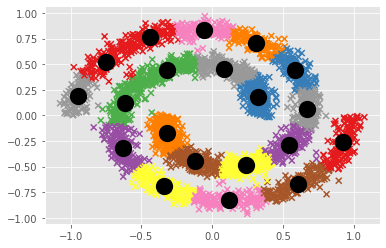

In [4]:
model = K_Means(k=20, tol=0.0001, max_iter=100)
model.fit(X)
plt.scatter(X[:,0], X[:,1], marker="x", c=model.classifications, cmap="Set1")
for centroid in model.centroids:
    plt.scatter(centroid[0], centroid[1],
                marker="o", color="k", s=150, linewidths=5)
plt.show()

## Implementação do classificador de Bayes com Mistura de Gaussinas

A regra de decisão de Bayes estabelece que o vetor **x** seja atribuido à classe $C_i$ de maior probabilidade posterior $P(C_i|$**x**$)$. Sendo $P(C_i|$**x**$)$ = $\frac{P(\textbf{x}|C_i)P(C_i)}{P(\textbf{x})}$.

Para um problema de classificação binário a regra de classificação pode ser expressa da seguinte forma:

![equation](eq.png)

onde $k=\frac{P(C_2)}{P(C_1)}$.

Generalizando, para problemas com 2 classes ou mais, basta atribuir a **x** a classe que resultar no maior valor da expressão $P(\textbf{x}|C_i)P(C_i)$.

Neste estudo cada classe será modelada como uma mistura de gaussianas de duas dimensões.
Os pontos que definirão os parâmetros de cada uma das gaussianas do modelo serão definidos pelo k-Means. A média de cada distribuição será definido pelos centróides do k-Means e a covariância será calculada com base nas amostras atribuídas a cada cluster. 

Assim, a função de densidade para cada classe é estimada por meio de uma combinação linear (mistura) das probabilidades em cada partição, conforme: 

$P(\textbf{x}|C_i) =  \sum_{k=1}^p \frac{N_k}{N} P(\textbf{x}|S_k)$

onde $N_k/N$ é a probabilidade da partição $S_k$, $N_k$ é o número de amostras de $S_k$, N é o total de amostras e  $P(\textbf{x}|S_k)$ é a probabilidade de **x** considerando somente amostras do cluster $S_k$.

In [5]:
# Bayes Classifier with GMM
class bayes_classifier:

    # To initialize the parameters from the Bayes algorithm:
    def __init__(self):
        self.p_ci = None
        self.X_train = None
        self.y_train = None
    
    # Gaussian function
    def kgaussian(self, u, h):
        K = 1/(math.sqrt(2*np.pi)*h) * math.exp(-0.5*(u**2))
        return K 

    # My KDE Implementation
    def gmm(self, x, class_i):
        N_train = self.X_train.shape[0]
        K_total = 0
        for c in range(int(self.n_centroids)):
            K_total += multivariate_normal.pdf(x, self.centroids[class_i][c], self.cov_list[class_i][c])
        return K_total*self.n_samples_cluster[class_i]/N_train
        
    # Training the model
    # Targets must start from 0. Example: for binary problem y=[0, 1] 
    def fit(self, X, y, n_centroids):
        self.X_train = X
        self.y_train = y
        self.n_centroids = n_centroids
        n = np.unique(y).shape[0]
        self.p_ci =  np.zeros(n)
        self.centroids = []
        self.cov_list = []
        self.n_samples_cluster = np.zeros(n_centroids)# number of samples of each cluster
        for i in range(0,n):
            self.cov_list.append([])
            n_elements = np.count_nonzero(self.y_train==np.unique(self.y_train)[i])
            total_elements = self.y_train.shape[0]
            self.p_ci[i] = n_elements/total_elements 
            kmeans = K_Means(k=int(n_centroids), tol=0.001, max_iter=1000)
            X = self.X_train[self.y_train==i]
            kmeans.fit(X)
            self.centroids.append(kmeans.centroids)
            for c in range(int(n_centroids)):
                self.cov_list[i].append(np.cov(X[kmeans.classifications==c, :], rowvar=False))
                self.n_samples_cluster[c] = X[kmeans.classifications==c, :].shape[0]
    
    # Function to classify data 
    def predict(self, X):
        # Calculate PDFs:
        y_hat = np.zeros(X.shape[0])
        n = np.unique(self.y_train).shape[0]
        pdf = np.zeros(n)
        y = np.zeros(X.shape[0]) 
        K = np.zeros(n)
        for j in range(0, X.shape[0]):
            for i in range(0,n):
                pdf[i] = self.gmm(X[j,:], i)
                #indexes = np.where(self.y_train==np.unique(self.y_train)[i])[0]
                K[i] = (pdf[i] * self.p_ci[i])
            y_hat[j] = np.unique(self.y_train)[K.argmax()]
        return y_hat

In [6]:
clf = bayes_classifier()
clf.fit(X, y, 10)
y = clf.predict(X)

iterations: 36
iterations: 58


## Superfície de Decisão

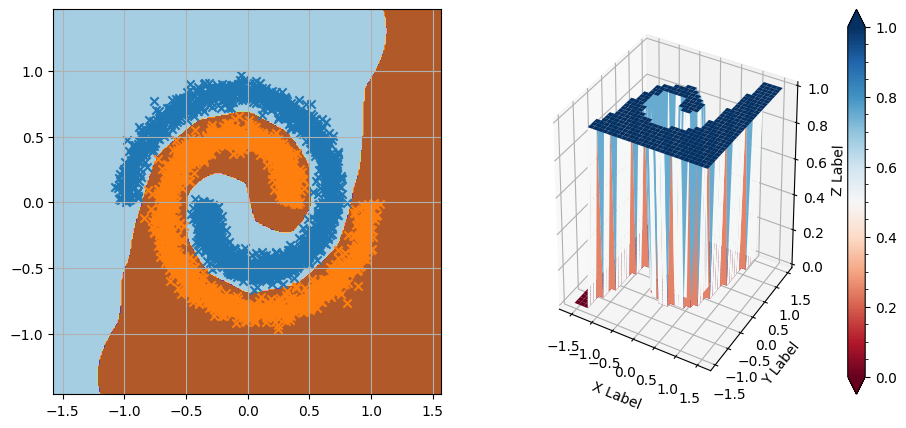

In [7]:
def plot_decision_border(X, y, clf):
    fig = plt.figure(figsize=(11,5))
    ax = fig.add_subplot(121)
    # decision surface for logistic regression on a binary classification dataset
    min1, max1 = X[:, 0].min()-0.5, X[:, 0].max()+0.5
    min2, max2 = X[:, 1].min()-0.5, X[:, 1].max()+0.5
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.01)
    x2grid = np.arange(min2, max2, 0.01)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    yhat=(clf.predict(grid))
    yhat=np.array(yhat)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='Paired')
    # create scatter plot for samples from each class
    for class_value in [0, 1]:
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired', marker='x')
    plt.grid()
    
    # plot surface:
    ax = fig.add_subplot(122, projection='3d')
    #create grid to evaluate model
    x = np.linspace(min1, max1, 30)
    y = np.linspace(min2, max2, 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    Z = clf.predict(xy).reshape(X.shape)
    Z=np.array(Z).reshape(X.shape)
    # plot decision boundary and margins
    figure = ax.plot_surface(X, Y, Z,rstride=1, cstride=1, cmap='RdBu',edgecolor='none')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    cbar = fig.colorbar(figure, ax=ax, extend='both')
    cbar.minorticks_on()
    plt.show()
    #plt.show() 
style.use('default')
plot_decision_border(X, y, clf)

## Superfícies das Misturas de Gaussianas

### Superfícies das Misturas em 3D

Os gráficos abaixo apresentam a superfície das misturas, correspondente às duas verossimilhanças $P(\textbf{x}|C_1)$ e $P(\textbf{x}|C_2)$.

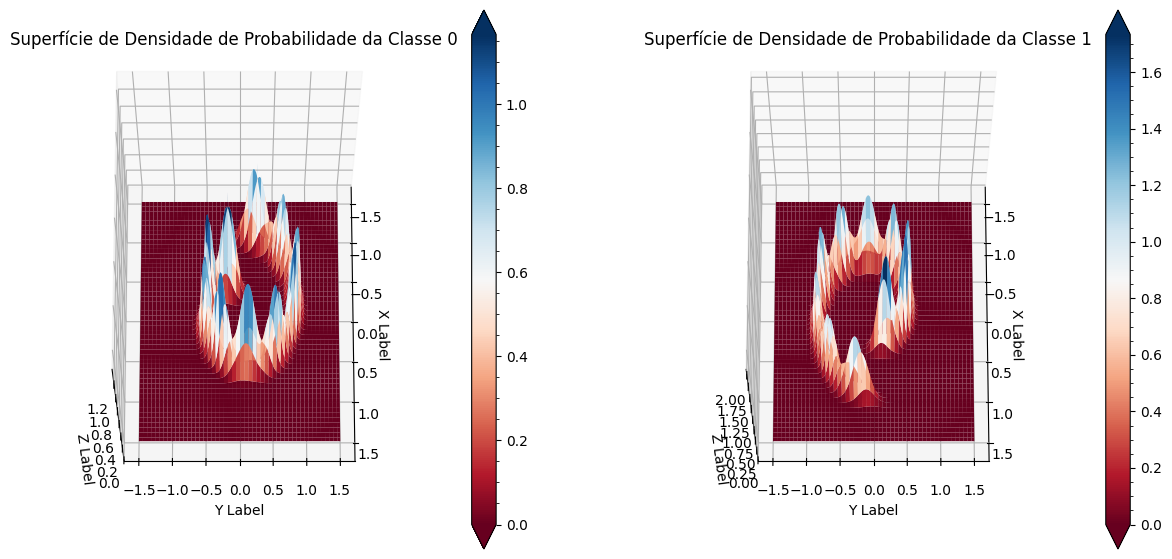

In [8]:
def plot_probability_density_surface(model, plot_support=True, x_min_max=(-1.5,1.5), y_min_max=(-1.5,1.5),  vectors_color="none"):
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot(121, projection='3d')
    # create grid to evaluate model
    x = np.linspace(x_min_max[0], x_min_max[1], 200)
    y = np.linspace(y_min_max[0], y_min_max[1], 200)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    Z = np.zeros(xy.shape[0])
    for i in range(xy.shape[0]):
        Z[i] = model.gmm(np.array(xy[i,:]), 0)
    Z=Z.reshape(X.shape)
    # plot decision boundary and margins
    figure= ax.plot_surface(X, Y, Z, cmap='RdBu',edgecolor='none')
    plt.title("Superfície de Densidade de Probabilidade da Classe 0")
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    #ax.axis('off')
    ax.view_init(70,0)
    cbar = fig.colorbar(figure, ax=ax, extend='both')
    cbar.minorticks_on()
    
    ax2 = fig.add_subplot(122, projection='3d')
    Z = np.zeros(xy.shape[0])
    for i in range(xy.shape[0]):
        Z[i] = model.gmm(np.array(xy[i,:]), 1)
    Z=Z.reshape(X.shape)
    # plot decision boundary and margins
    figure= ax2.plot_surface(X, Y, Z, cmap='RdBu',edgecolor='none')
    ax2.set_xlabel('X Label')
    ax2.set_ylabel('Y Label')
    ax2.set_zlabel('Z Label')
    plt.title("Superfície de Densidade de Probabilidade da Classe 1")
    #ax.axis('off')
    ax2.view_init(70,0)
    cbar = fig.colorbar(figure, ax=ax2, extend='both')
    cbar.minorticks_on()
     
plot_probability_density_surface(model = clf);

### Contornos de cada Mistura e da Superfície de Separação

O gráfico abaixo apresenta as amostras de cada classe, os contornos de cada mistura, correspondentes a $P(\textbf{x}|C_1)$ e $P(\textbf{x}|C_2)$, e o contorno da superfície de separação resultante da aplicação da regra de Bayes.

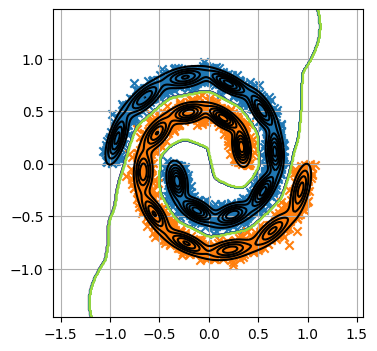

In [9]:
def plot_level_curves(X, y, clf):
    fig = plt.figure(figsize=(4,4))
    # decision surface for logistic regression on a binary classification dataset
    min1, max1 = X[:, 0].min()-0.5, X[:, 0].max()+0.5
    min2, max2 = X[:, 1].min()-0.5, X[:, 1].max()+0.5
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.01)
    x2grid = np.arange(min2, max2, 0.01)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # create scatter plot for samples from each class
    for class_value in [0, 1]:
        # make predictions for the grid
        yhat=(clf.gmm(grid, class_value))
        yhat=np.array(yhat)
        # reshape the predictions back into a grid
        zz = yhat.reshape(xx.shape)
        plt.contour(xx, yy, zz, colors='black')
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired', marker='x')
    yhat=(clf.predict(grid))
    yhat=np.array(yhat)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    plt.contour(xx, yy, zz)
    plt.grid()
    plt.title
plot_level_curves(X, y, clf)

## 10-fold Cross Validation

In [16]:
n_splits = 10
k_fold = StratifiedKFold(n_splits=n_splits, shuffle=True)
acc = np.zeros(n_splits)
for c in [5, 10, 20]:
    i = 0
    for train_indices, test_indices in k_fold.split(X, y):
        clf = bayes_classifier()
        clf.fit(X[train_indices], y[train_indices], c)
        y_pred = clf.predict(X[test_indices])
        acc[i] = accuracy_score(y[test_indices], y_pred)
        i +=1
    print(f"\nAcurácia Média (modelo com {c} clusters por classe): " + '{:.4f}'.format(acc.mean()) + "+/-" + '{:.4f}'.format(acc.std())) 


Acurácia Média (modelo com 5 clusters por classe): 0.9943+/-0.0045

Acurácia Média (modelo com 10 clusters por classe): 0.9997+/-0.0010

Acurácia Média (modelo com 20 clusters por classe): 0.9997+/-0.0010


Aparentemente, dentre os 3 modelos testados, os que obtiveram melhores resultados foram os que utilizam 10 e 20 clusters por classe. Contudo, como esses 2 modelos obtiveram performances semelhantes, é razoável dizer que uma escolha melhor seria o modelo que utiliza 10 clusters por classe. É facilmente observado que quanto maior o número de clusters maior o esforço computacional (e também maior a chance de overfitting).

Assim, para o modelo utilizando uma mistura de 10 gaussianas por classe, foi também gerada a matriz de confusão obtida a partir da aplicação da validação cruzada de 10 folds. 

In [22]:
predicted_classes = []
actual_classes = []
i = 0
for train_indices, test_indices in k_fold.split(X, y):
    clf = bayes_classifier()
    clf.fit(X[train_indices], y[train_indices], 10)
    y_pred = clf.predict(X[test_indices])
    predicted_classes = np.append(predicted_classes, y_pred)
    actual_classes = np.append(actual_classes, y[test_indices])
    acc[i] = accuracy_score(y[test_indices], y_pred)
    i +=1
    
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):
    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    plt.figure(figsize=(6,3))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
    plt.show()

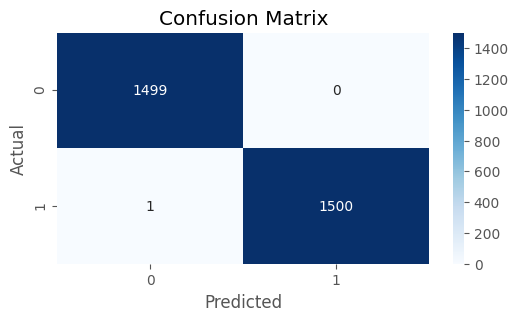

In [23]:
plot_confusion_matrix(actual_classes, predicted_classes, [0, 1])

## Conclusão

Neste exercício foi possível implementar e testar o funcionamento de um classificador de Bayes cuja as classes foram modeladas como uma mistura de gaussianas de duas dimensões. Os pontos que definiram os parâmetros de cada uma das gaussianas do modelo foram definidos através do algoritmo k-Means.

Assim, a primeira parte do exercício foi justamente implementar o algoritmo de *clustering* e testá-lo. Depois disso, foi desenvolvido o classificador Bayesianno, como explicado, e os gráficos da superfície de separação e da superfície de densidade de probabilidade foram gerados.

Por fim, foi utilizada a técnica de validação cruzada (utilizando 10 folds) para avaliar o classificador. Como visto, o classificador que utilizou 10 gaussianas para modelar cada classe teve um desempenho considerado melhor (foi o que obteve melhor acurácia média com menor custo computacional). Contudo, todos os 3 classificadores (utilizando 5, 10 e 20 gaussianas para cada classe) obtiveram resultados de acurácia média próximos de 100%. Com isso, foi possível observar a eficiência do método em resolver problemas como o deste ensaio.